# TGS ヒステリシス曲線

## 前処理

BTO のヒステリシス曲線の測定データを処理するコード

まずはライブラリのインポートから

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from matplotlib.colors import Normalize
from scipy.optimize import curve_fit

ファイル名と温度・電圧の対応

In [3]:
temp = []
volt = []
# 室温から40度までのデータ
for i in range(3):
    for j in range(15):
        if (i == 0):
            temp.append(22.9)
        elif (i ==  1):
            temp.append(35)
        elif (i == 2):
            temp.append(40)
        elif (i == 3):
            temp.append(45)
        volt.append((j+1)*10.0)
temp.append(45)
volt.append(5)
for j in range(15):
        temp.append(45)
        volt.append((j+1)*10.0)
# 125度からのデータ
for i in range(62, 81):
    volt.append(150)
# 温度は手打ち
temp.append(47)
temp.append(49)
temp.append(51)
temp.append(53)
temp.append(55)

temp.append(60)
temp.append(65)
temp.append(70)

temp.append(70)
temp.append(65)
temp.append(60)

 #ここら辺から怪しい
temp.append(55)
# temp.append(53)
temp.append(51)
temp.append(49)
temp.append(47)

temp.append(45)
temp.append(40)

temp.append(35)
temp.append(30)

temp = np.array(temp)
volt = np.array(volt)

heating_index = [14, 29, 44, 60, 61, 62, 63, 64, 65, 66, 67, 68]
cooling_index = list(range(69,80))
fero_index = [14, 29, 44, 60, 61, 62, 74, 75, 76, 77, 78, 79]

csv ファイルのインポート。
データフレームにした後、電圧だけを取り出して、x 軸に電場、y軸に電束密度にする。
BTO を入れたコンデンサのパラメータ、厚さを thin 面積を area としてる。

In [4]:
thin = 200                  # マイクロメートル
area = 2.9                   # 平方ミリメートル
epsilon0 = 0.88541878188    # 真空の誘電率 nF/cm

csv からデータを読み取とり、data 変数に入れる

data[何番目のファイル][i][成分]

i = 0 時刻、 i = 1 電場, i = 2 分極、i = 3 電圧、 i = 4 温度

In [5]:
nfile = 80
data = np.zeros((nfile, 5, 1000))
for i in range(1, nfile+1):
    df = pd.read_csv(f"2024_10_11_TGS/ALL{i:04}.CSV", skiprows=24, usecols = [0,1,3])
    data[i-1][0][:] = df.iloc[:,0].values
    data[i-1][1][:] = df.iloc[:,1].values / thin * 100 # kV/cm
    data[i-1][2][:] = df.iloc[:,2].values / area * 10  # uC/cm^2
    data[i-1][3][:] = volt[i-1]
    data[i-1][4][:] = temp[i-1]

# 移動平均によるフィルターと平均からのずれの補正
window_size = 10
for i in range(nfile):
    Emean = np.mean(data[i][1][:])
    Pmean = np.mean(data[i][2][:])
    for j in range(0, 1000-window_size):
        data[i][1][j] = np.mean(data[i][1][j:j+window_size]) - Emean
        data[i][2][j] = np.mean(data[i][2][j:j+window_size]) - Pmean

関数のフィッティングをする。
常誘電相では
$$
 f(T) = A(T-T_c)^a +B
$$
強誘電相では
$$
 f(T) = A(T_c-T)^a +B
$$
としてフィッティングする。

In [6]:
def parafit(x, Tc, A, B, a):
    return A* ((x-Tc)*(x-Tc))**(a/2) + B

def ferofit(x, Tc, A, B, a):
    return A* (Tc-x)**a + B

## 解析

### 降伏電場

正の方の降伏電場と負の方の降伏電場、合わせて5個の平均をとる。
降伏電場の選び方としては単純に D が最も 0 に近いときの E の値を選ぶという方法をとる。

ただし、かけた電場が弱いとオシロスコープの分解能が対応しないため信用ならない値となる。

また、TGS ではオシロスコープの測定点・分解能ともに悪いため 51 ℃ 以上では 0 であるとみなした。

In [7]:
Ec = np.zeros(nfile)
for i in range(nfile):
    if((i >= 63) and (i <= 73)):
        continue
    Ec[i] += data[i][1][np.argmin(np.abs(data[i][2][0:200]))]
    Ec[i] -= data[i][1][np.argmin(np.abs(data[i][2][200:400]))+200]
    Ec[i] += data[i][1][np.argmin(np.abs(data[i][2][400:600]))+400]
    Ec[i] -= data[i][1][np.argmin(np.abs(data[i][2][600:800]))+600]
    Ec[i] += data[i][1][np.argmin(np.abs(data[i][2][800:1000]))+800]
    Ec[i] /= 5

強誘電相での電圧依存性

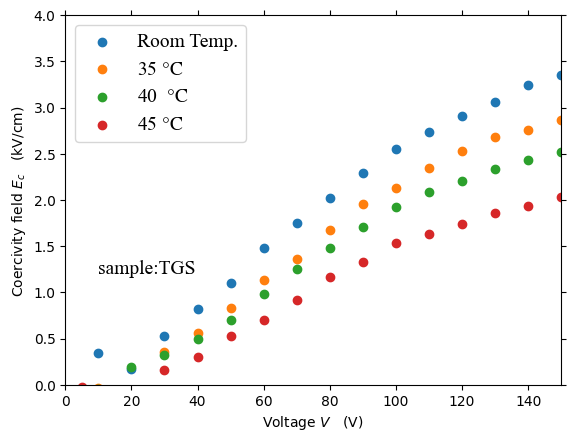

In [8]:
# 目盛を上下作用にセット
f = plt.figure()
ax = f.add_subplot(111)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# プロットエリアの範囲等の整備
plt.xlim(0,150)
plt.ylim(0,4)

# フォントの選択
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] ='Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'

# 軸ラベル
plt.xlabel("Voltage $ V \quad\mathrm{(V)}$")
plt.ylabel("Coercivity field $ E_c \quad(\mathrm{kV/cm)}$ ")

# プロット
plt.scatter(volt[ 0:15],Ec[ 0:15], label = "Room Temp.")
plt.scatter(volt[15:30],Ec[15:30], label = "35 $\mathrm{\degree C}$")
plt.scatter(volt[30:45],Ec[30:45], label = "40  $\mathrm{\degree C}$")
plt.scatter(volt[45:61],Ec[45:61], label = "45 $\mathrm{\degree C}$")

# 凡例
plt.legend()

# その他要素
plt.text(10, 1.2, "sample:TGS", backgroundcolor = "white")


plt.show()

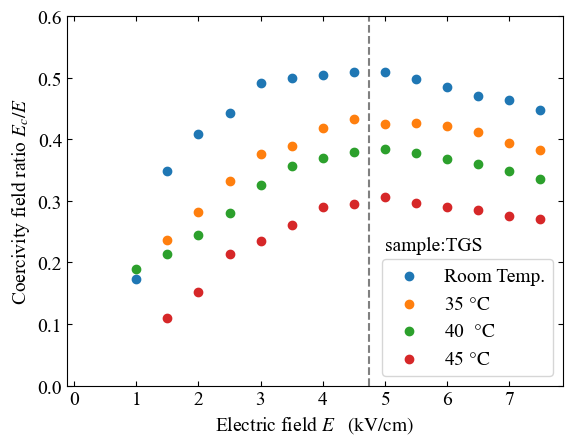

In [9]:
# 目盛を上下作用にセット
f = plt.figure()
ax = f.add_subplot(111)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# プロットエリアの範囲等の整備
# plt.xlim(0,150)
plt.ylim(0,0.6)

# フォントの選択
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] ='Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'

# 軸ラベル
plt.xlabel("Electric field $ E \quad\mathrm{(kV/cm)}$")
plt.ylabel("Coercivity field ratio $ E_c/E$ ")

# プロット
plt.scatter(volt[ 0:15] / thin * 10,Ec[ 0:15]/(volt[ 0:15] / thin * 10), label = "Room Temp.")
plt.scatter(volt[15:30] / thin * 10,Ec[15:30]/(volt[15:30] / thin * 10), label = "35 $\mathrm{\degree C}$")
plt.scatter(volt[30:45] / thin * 10,Ec[30:45]/(volt[30:45] / thin * 10), label = "40  $\mathrm{\degree C}$")
plt.scatter(volt[45:61] / thin * 10,Ec[45:61]/(volt[45:61] / thin * 10), label = "45 $\mathrm{\degree C}$")

# 凡例
plt.legend()

# その他要素
plt.vlines(4.75, 0, 0.6, linestyles="dashed", color = "grey")
# plt.vlines(1.25, 0, 0.3, linestyles="dashed", color = "grey")
plt.text(5, 0.22, "sample:TGS", backgroundcolor = "white")


plt.show()

こんな感じに分けれる気がする。

In [10]:
# # 目盛を上下作用にセット
# f = plt.figure()
# ax = f.add_subplot(111)
# ax.yaxis.set_ticks_position('both')
# ax.xaxis.set_ticks_position('both')
# plt.rcParams['xtick.direction'] = 'in'
# plt.rcParams['ytick.direction'] = 'in'

# # プロットエリアの範囲等の整備
# plt.xlim(0,150)
# plt.ylim(0,2)

# # フォントの選択
# plt.rcParams['font.size'] = 14
# plt.rcParams['font.family'] ='Times New Roman'
# plt.rcParams['mathtext.fontset'] = 'stix'

# # 軸ラベル
# plt.xlabel("Voltage $ V \quad\mathrm{(V)}$")
# plt.ylabel("Coercivity field $ E_c \quad(\mathrm{kV/cm)}$ ")

# # プロット
# plt.scatter(volt[ 0:15],Ec[ 0:15], label = "Room Temp.")
# plt.scatter(volt[15:30],Ec[15:30], label = "35 $\mathrm{\degree C}$")
# plt.scatter(volt[30:45],Ec[30:45], label = "40  $\mathrm{\degree C}$")
# plt.scatter(volt[45:61],Ec[45:61], label = "45 $\mathrm{\degree C}$")

# # 凡例
# plt.legend()

# # その他要素
# plt.plot([95, 150], [1.35, 1.95], color = "tab:blue")
# plt.plot([20, 95], [0, 1.35], color = "tab:blue")
# plt.plot([95, 150], [1.15, 1.75], color = "tab:orange")
# plt.plot([20, 95], [0, 1.15], color = "tab:orange")
# plt.plot([95, 150], [1.00, 1.55], color = "tab:green")
# plt.plot([20, 95], [0, 1.00], color = "tab:green")
# plt.plot([95, 150], [0.80, 1.25], color = "tab:red")
# plt.plot([20, 95], [0, 0.80], color = "tab:red")
# plt.vlines(95, 0, 2, linestyles="dashed", color = "grey")
# plt.vlines(25, 0, 2, linestyles="dashed", color = "grey")
# plt.text(10, 1.2, "sample:TGS", backgroundcolor = "white")


# plt.show()

たぶんこんな感じに分けることができて、
- 電圧が小さいとき:
  
  オスロスコープがダメ
- 電圧が高くないとき:
  
  降伏電場に達する前に折り返している。ここではヒステリシスの面積が書けた電圧のp2pに比例?
- 電圧が高いとき：
  
  結晶粒や欠陥のせいでヒステリシスがなめるためゆっくりと飽和に向かっていく


強誘電相でのべき則を確かめる

[5.17766784e+01 1.00000000e+00 1.00000000e-02 3.64965614e-01]
[50.4, 0.05, 0, 1.6]


C:\Users\xiang\AppData\Local\Temp\ipykernel_6388\4272899956.py:5: RuntimeWarning: invalid value encountered in power
  return A* (Tc-x)**a + B


Text(56, 0.4, '$T_c = 51.8 \\degree$C')

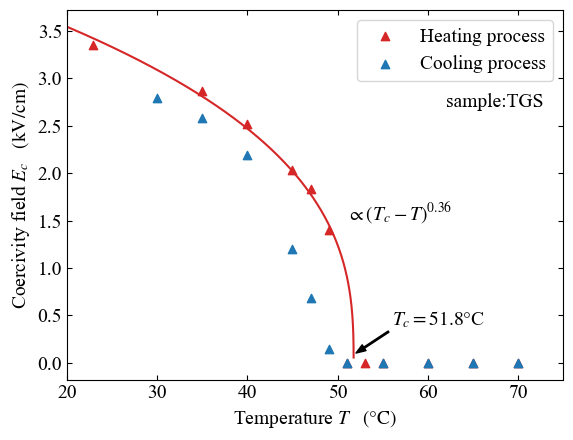

In [11]:
initial_guess = [53, 0.84, 0.0, 0.239]
lower_bounds =[49, 0.2, -0.01, 0]
upper_bounds =[53, 1, 0.01, 1]
popt = curve_fit(ferofit, temp[fero_index][:6], Ec[fero_index][:6], p0=initial_guess, bounds=(lower_bounds, upper_bounds), maxfev=5000)[0]
print(popt)

fitcurve = lambda T: ferofit(T, *popt)
T_values = np.linspace(20,55,100000)

popt2 = [50.4, 0.05, 0, 1.6]
print(popt2)

fitcurve2 = lambda T: ferofit(T, *popt2)
T_values2 = np.linspace(43,55,100)


# 目盛を上下作用にセット
f = plt.figure()
ax = f.add_subplot(111)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# プロットエリアの範囲等の整備
plt.xlim(20,75)
# plt.yticks([0, 0.5, 1, 1.5, 2.0])
# plt.ylim(0,2)

# フォントの選択
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] ='Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'

# 軸ラベル
plt.xlabel("Temperature $ T \quad\mathrm{(\degree C)}$")
plt.ylabel("Coercivity field $ E_c \quad(\mathrm{kV/cm)}$ ")

plt.plot(T_values,fitcurve(T_values), color = "tab:red")
# plt.plot(T_values2,fitcurve2(T_values2), color = "tab:blue")
plt.scatter(temp[heating_index],Ec[heating_index], color = "tab:red", marker = "^", label = "Heating process")
plt.scatter(temp[cooling_index],Ec[cooling_index], color = "tab:blue", marker = "^", label = "Cooling process")

plt.legend()
plt.text(51, 1.5, "$\propto(T_c-T)^{0.36}$", backgroundcolor = "white")
# plt.text(35, 0.2, "$\propto(T_c-T)^{1.6}$", backgroundcolor = "white")
plt.text(62, 2.7, "sample:TGS", backgroundcolor = "white")
plt.annotate(text="$T_c = 51.8 \degree$C", xy=(52,0.1), xytext=(56,0.4), arrowprops=dict(color='black', width =1.0,headwidth=5.0,headlength=7.0,shrink=0.01))


$$
    F = f_0(T) + \frac{\alpha}{2}p^2 + \frac{\beta}{2}p^4
$$
という自由エネルギーを考えると降伏電場$E_c$は
$$
    E_c = \sqrt{\frac{-4\alpha^3}{27\beta}}
$$
となる。普通は$\alpha = (T-T_c)$とするので、この結果と見比べると
なんか苦しい

たぶんこんな感じに分けることができて、
- 電圧が小さいとき:
  
  オスロスコープがダメ
- 電圧が高くないとき:
  
  降伏電場に達する前に折り返している。ここではヒステリシスの面積が書けた電圧のp2pに比例?
- 電圧が高いとき：
  
  結晶粒や欠陥のせいでヒステリシスがなめるためゆっくりと飽和に向かっていく

### 自発分極（飽和磁化からの外挿）

実験で指示があった飽和分極付近での傾きを使って外挿する方法である。
飽和分極付近では強誘電性による分極が終わり他の常誘電てきな応答によるものしかないとみなす。
するとこの傾きは常誘電性の感受率になるので、ここ付近の値を線形近似し、
y軸での値を読み取るとそれは自発分極による寄与だとみなせる。

式で説明すると
誘電体中の電束密度は自発分極 $P_s$ と
常誘電的な $P(E) = \varepsilon_0\chi E$ の2つを用いて
$$
    D = \varepsilon_0 E + P(E) + P_s = \varepsilon_0 (1 + \chi)E + P_s 
$$
と書ける。飽和磁化付近では$P_s$は一定であるため、
線形近似したときの傾きは $\varepsilon_0(1+\chi)$となる。
なので直線を外挿して$E=0$での$D$の値を読むとそれが自発分極であるというのがわかる。

かけた電場が折り返す地点はわかるのでそこから polyfit 使って線形近似で残留分極を求める。

In [12]:
k = 49
Ps = np.zeros(nfile)
for i in range(nfile):

    k2 = np.argmax(data[i][1][100:300])
    a2 = np.polyfit(data[i][1][100+k2:100+k2+k], data[i][2][100+k2:100+k2+k], 1)[1]

    k3 = np.argmin(data[i][1][300:500])
    a3 = np.polyfit(data[i][1][300+k3:300+k3+k], data[i][2][300+k3:300+k3+k], 1)[1]

    k4 = np.argmax(data[i][1][500:700])
    a4 = np.polyfit(data[i][1][500+k4:500+k4+k], data[i][2][500+k4:500+k4+k], 1)[1]

    k5 = np.argmin(data[i][1][700:900])
    a5 = np.polyfit(data[i][1][700+k5:700+k5+k], data[i][2][700+k5:700+k5+k], 1)[1]

    Ps[i] = (a2 - a3 + a4 - a5)/4

[4.99806942e+01 1.13486403e+00 1.28061875e-18 4.15426906e-01]


C:\Users\xiang\AppData\Local\Temp\ipykernel_6388\4272899956.py:5: RuntimeWarning: invalid value encountered in power
  return A* (Tc-x)**a + B


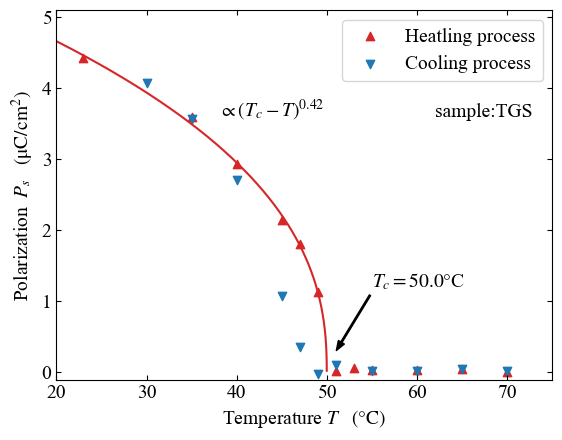

In [13]:
initial_guess = [50,0.8, 0,0.5]
lower_bounds =[49, 0.5, 0.0, 0.40]
upper_bounds =[51, 1.5, 0.1, 0.55]
popt = curve_fit(ferofit, temp[fero_index][:6], Ps[fero_index][:6], p0=initial_guess, bounds=(lower_bounds, upper_bounds), maxfev=5000)[0]
print(popt)

# fitcurve = lambda T: ferofit(T, popt[0],popt[1], popt[2],popt[3])
# T_values = np.linspace(20,55,100000)

# popt2 = [48.5, 0.45, 0, 0.85]
# print(popt2)

# fitcurve2 = lambda T: ferofit(T, *popt2)
# T_values2 = np.linspace(39,55,100)


# 目盛を上下作用にセット
f = plt.figure()
ax = f.add_subplot(111)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# プロットエリアの範囲等の整備
plt.xlim(20,75)
plt.ylim(-0.1,5.1)
# plt.xticks([-3,-2,-1,0,1,2,3])
plt.hlines([0],-3.5,3.5, "black")
plt.vlines([0],-3.5,3.5, "black")

# フォントの選択
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] ='Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'

# 軸ラベル
plt.xlabel("Temperature $ T \quad\mathrm{(\degree C)}$")
plt.ylabel("Polarization  $ P_s \quad(\mathrm{\mu C/cm^2)}$ ")

# プロット
plt.plot(T_values,fitcurve(T_values), color = "tab:red")
# plt.plot(T_values2,fitcurve2(T_values2), color = "tab:blue")
plt.scatter(temp[heating_index],Ps[heating_index], color = "tab:red",marker="^", label="Heatling process")
plt.scatter(temp[cooling_index],Ps[cooling_index], color = "tab:blue",marker="v", label="Cooling process")

plt.legend()
plt.text(38, 3.6, "$\propto(T_c-T)^{0.42}$", backgroundcolor = "white")
plt.text(62, 3.6, "sample:TGS", backgroundcolor = "white")
plt.annotate(text="$T_c = 50.0 \degree$C", xy=(51,0.3), xytext=(55,1.2), arrowprops=dict(color='black', width =1.0,headwidth=5.0,headlength=7.0,shrink=0.01))

plt.show()

$$
    F = f_0(T) + \frac{\alpha}{2}p^2 + \frac{\beta}{2}p^4
$$
という自由エネルギーを考えると自発分極$P_s$は
$$
    Ps = \sqrt{\frac{-\alpha}{\beta}}
$$
となる。普通は$\alpha = (T-T_c)$とするので、この結果と見比べると
$$
    \beta = (T_c -T)^{0.1}
$$
とかになる気がする。

### ヒステリシス損
2次元閉曲線を表す点群の内部の面積を数値計算で求める方法として、**多角形の面積を計算するアルゴリズム**がよく使われます。特に、**シュー・レーシング（shoelace formula）**、または**ガウスの面積公式**が便利です。これにより、点群で定義された閉曲線の面積を効率的に計算することができます。

手順は次の通りです：

1. 点群の順序を定義
点群が $(x_1, y_1), (x_2, y_2), \dots, (x_n, y_n)$ で与えられているとします。この点群が閉曲線を定義しているので、最初の点と最後の点は一致しない場合、最初の点に戻るように点を追加して閉じる必要があります。

2. シュー・レーシング公式の適用
点群を使って、面積 $A$ を以下の式で計算します。

$$
A = \frac{1}{2} \left| \sum_{i=1}^{n} (x_i y_{i+1} - y_i x_{i+1}) \right|
$$

ここで、$ (x_{n+1}, y_{n+1}) $ は $ (x_1, y_1) $ です。


3. 注意点
- 点群が時計回りか反時計回りかによって面積の符号が変わることがありますが、絶対値をとることで正の面積を得られます。
- 曲線が複雑な場合や凹凸がある場合は、点群の順序に注意が必要です。

In [14]:
hysterisis_loss = np.zeros(nfile)
for i in range(nfile):
    temp_area = 0
    x1 = data[i][1][0:800]
    y1 = data[i][2][0:800]
    x2 = data[i][1][1:801]
    y2 = data[i][2][1:801]
    hysterisis_loss[i] = np.abs(np.dot(x1, y2) - np.dot(y1, x2))/4

電圧依存性

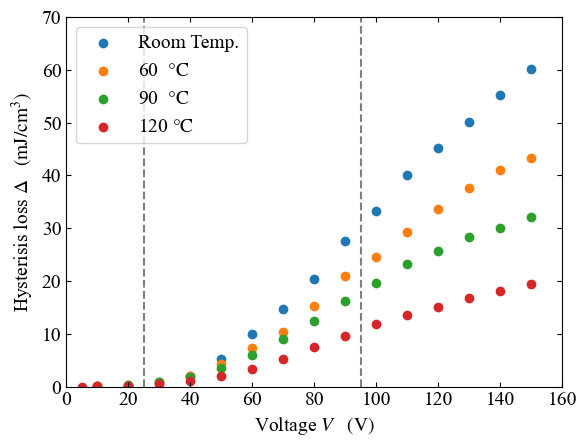

In [15]:
# 目盛を上下作用にセット
f = plt.figure()
ax = f.add_subplot(111)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# プロットエリアの範囲等の整備
plt.xlim(0,160)
plt.ylim(0,70)

# フォントの選択
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] ='Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'

# 軸ラベル
plt.xlabel("Voltage $ V \quad\mathrm{(V)}$")
plt.ylabel("Hysterisis loss $ \Delta \quad(\mathrm{mJ/cm^3)}$ ")

# プロット
plt.scatter(volt[ 0:15],hysterisis_loss[ 0:15], label = "Room Temp.")
plt.scatter(volt[15:30],hysterisis_loss[15:30], label = "60  $\mathrm{\degree C}$")
plt.scatter(volt[30:45],hysterisis_loss[30:45], label = "90  $\mathrm{\degree C}$")
plt.scatter(volt[45:61],hysterisis_loss[45:61], label = "120 $\mathrm{\degree C}$")


plt.vlines(95, 0, 70, linestyles="dashed", color = "grey")
plt.vlines(25, 0, 70, linestyles="dashed", color = "grey")

# 凡例
plt.legend()

plt.show()

温度依存性

[5.06957168e+01 6.00000000e+00 1.00000000e-02 6.99509836e-01]
[50.4, 0.45, 0, 1.75]


C:\Users\xiang\AppData\Local\Temp\ipykernel_6388\4272899956.py:5: RuntimeWarning: invalid value encountered in power
  return A* (Tc-x)**a + B


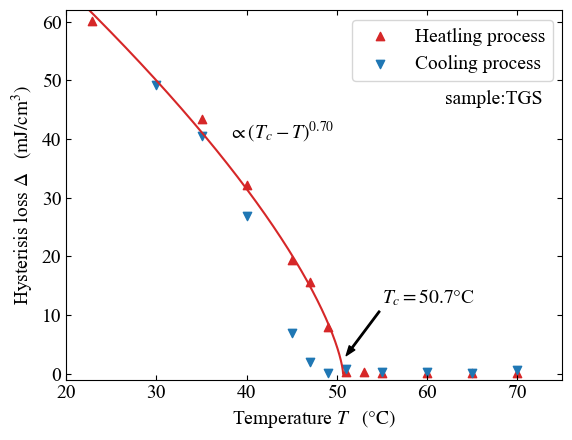

In [16]:
initial_guess = [49, 4, 0.0, 0.7]
lower_bounds =[49, 3, -0.01, 0.6]
upper_bounds =[53, 6, 0.01, 1]
popt = curve_fit(ferofit, temp[fero_index][:6], hysterisis_loss[fero_index][:6], p0=initial_guess, bounds=(lower_bounds, upper_bounds), maxfev=5000)[0]
print(popt)

fitcurve = lambda T: ferofit(T, popt[0],popt[1], popt[2],popt[3])
T_values = np.linspace(20,55,100000)

popt2 = [50.4, 0.45, 0, 1.75]
print(popt2)

fitcurve2 = lambda T: ferofit(T, *popt2)
T_values2 = np.linspace(39,55,100)

# 目盛を上下作用にセット
f = plt.figure()
ax = f.add_subplot(111)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# プロットエリアの範囲等の整備
plt.xlim(20,75)
plt.ylim(-1,62)
# plt.xticks([-3,-2,-1,0,1,2,3])
plt.hlines([0],-3.5,3.5, "black")
plt.vlines([0],-3.5,3.5, "black")

# フォントの選択
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] ='Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'

# 軸ラベル
plt.xlabel("Temperature $ T \quad\mathrm{(\degree C)}$")
plt.ylabel("Hysterisis loss $ \Delta \quad(\mathrm{mJ/cm^3)}$ ")

# プロット
plt.plot(T_values,fitcurve(T_values), color = "tab:red")
# plt.plot(T_values2,fitcurve2(T_values2), color = "tab:blue")
plt.scatter(temp[heating_index],hysterisis_loss[heating_index], color = "tab:red",marker="^", label="Heatling process")
plt.scatter(temp[cooling_index],hysterisis_loss[cooling_index], color = "tab:blue",marker="v", label="Cooling process")
# plt.plot(temp[heating_index],hysterisis_loss[heating_index], color = "tab:red")
# plt.plot(temp[cooling_index],hysterisis_loss[cooling_index], color = "tab:blue")

plt.legend()
plt.text(38, 40, "$\propto(T_c-T)^{0.70}$")
# plt.text(30, 10, "$\propto(T_c-T)^{1.75}$")
plt.text(62, 46, "sample:TGS", backgroundcolor = "white")
plt.annotate(text="$T_c = 50.7 \degree$C", xy=(51,3), xytext=(55,12), arrowprops=dict(color='black', width =1.0,headwidth=5.0,headlength=7.0,shrink=0.01))

plt.show()

$\Delta \propto E_c P_s $ 説

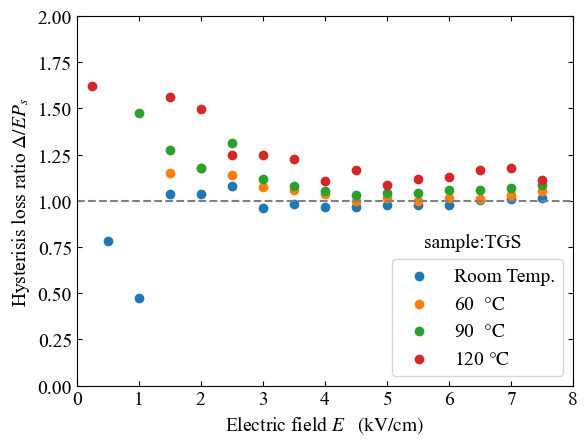

In [17]:
# 目盛を上下作用にセット
f = plt.figure()
ax = f.add_subplot(111)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# プロットエリアの範囲等の整備
plt.xlim(0,8)
plt.ylim(0.0,2.0)

# フォントの選択
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] ='Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'

# 軸ラベル
plt.xlabel("Electric field $ E \quad\mathrm{(kV/cm)}$")
plt.ylabel("Hysterisis loss ratio $ \Delta/E P_s $ ")

# プロット
plt.scatter(volt[ 0:15] / thin * 10,hysterisis_loss[ 0:15]/(Ps[ 0:15] * Ec[ 0:15]*4), label = "Room Temp.")
plt.scatter(volt[15:30] / thin * 10,hysterisis_loss[15:30]/(Ps[15:30] * Ec[15:30]*4), label = "60  $\mathrm{\degree C}$")
plt.scatter(volt[30:45] / thin * 10,hysterisis_loss[30:45]/(Ps[30:45] * Ec[30:45]*4), label = "90  $\mathrm{\degree C}$")
plt.scatter(volt[45:61] / thin * 10,hysterisis_loss[45:61]/(Ps[45:61] * Ec[45:61]*4), label = "120 $\mathrm{\degree C}$")


plt.hlines(1.0, 0, 8, linestyles="dashed", color = "grey")
# plt.vlines(1.25, 0, 1.4, linestyles="dashed", color = "grey")
plt.text(5.6, 0.75, "sample:TGS", backgroundcolor = "white")

# 凡例
plt.legend(loc = "lower right")

plt.show()

In [18]:
Ps_h = hysterisis_loss / Ec / 4

C:\Users\xiang\AppData\Local\Temp\ipykernel_6388\1785292217.py:1: RuntimeWarning: divide by zero encountered in divide
  Ps_h = hysterisis_loss / Ec / 4


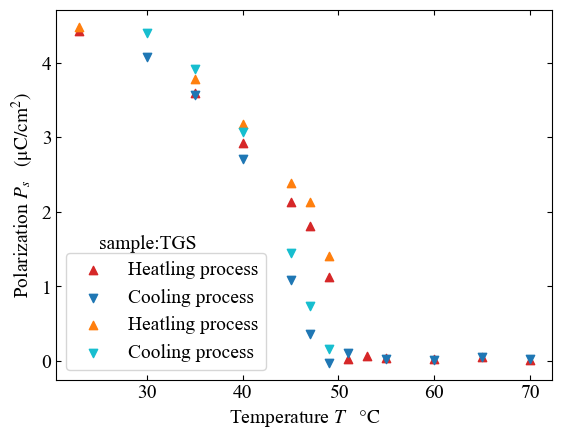

In [37]:
# 目盛を上下作用にセット
f = plt.figure()
ax = f.add_subplot(111)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# プロットエリアの範囲等の整備
# plt.xlim(20,180)
# plt.ylim(-0.1,4.1)
plt.yticks([0, 1, 2, 3, 4])

# フォントの選択
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] ='Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'

# 軸ラベル
plt.xlabel("Temperature $ T \quad\mathrm{\degree C}$")
plt.ylabel("Polarization $ P_s \quad\mathrm{(\mu C/cm^2)}$")

# プロット
plt.scatter(temp[heating_index],Ps[heating_index], color = "tab:red", marker = "^", label = "Heatling process")
plt.scatter(temp[cooling_index],Ps[cooling_index], color = "tab:blue", marker = "v", label="Cooling process")
plt.scatter(temp[heating_index],Ps_h[heating_index], color = "tab:orange", marker = "^", label = "Heatling process")
plt.scatter(temp[cooling_index],Ps_h[cooling_index], color = "tab:cyan", marker = "v", label="Cooling process")

plt.legend(loc = "lower left")
# その他要素
plt.text(25, 1.5, "sample:TGS")


plt.show()

### スケーリング則

スケーリング則とかで調べることになる電気感受率等を計算する。

70.0


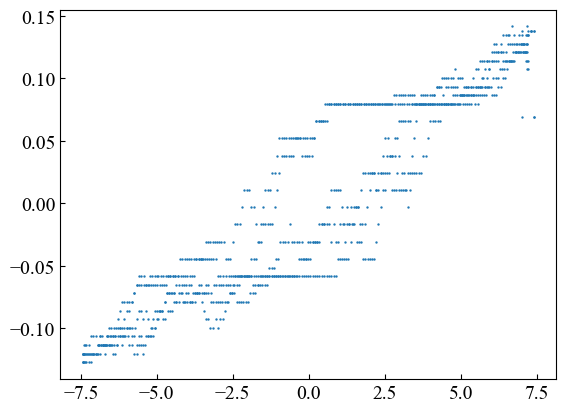

In [20]:
i = 69
print(temp[i])
plt.scatter(data[i][1],data[i][2], s=0.5)

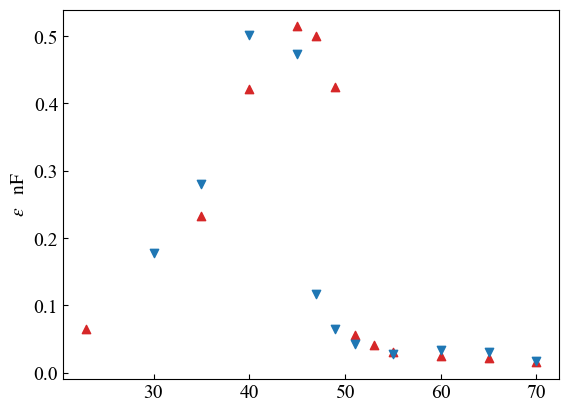

In [21]:
epsilon = np.zeros(nfile)
for i in range(nfile):
    if((i >= 63) and (i <= 75)):
        epsilon[i] = np.polyfit(data[i][1], data[i][2], 1)[0]
        continue
    for j in range(1,5):
        k = np.argmin(np.abs(data[i][1][j*200:(j+1)*200]))
        k1 = np.polyfit(data[i][1][j*200+k-10:j*200+k+10],data[i][2][j*200+k-10:j*200+k+10],1)[0]
        epsilon[i] += k1
    epsilon[i] = epsilon[i]/4
chi = epsilon/epsilon0 - 1
# plt.xlim(47,70)
plt.ylabel("$\epsilon \quad\mathrm{nF}$")
plt.scatter(temp[heating_index],epsilon[heating_index], c="tab:red", marker="^")
plt.scatter(temp[cooling_index],epsilon[cooling_index], c="tab:blue", marker="v")

[ 4.70000012e+01  1.35719932e-01  1.54406977e-02 -1.00000000e+00]


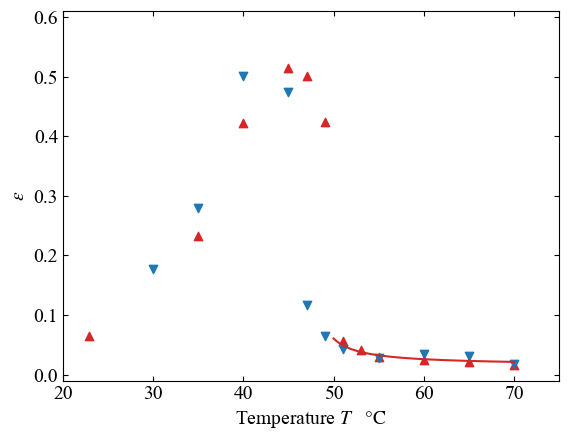

In [22]:
initial_guess = [50, 0.15, 0.0, -1]
lower_bounds =[47.0, 0.01, -0.1, -1.01]
upper_bounds =[51, 0.3, 0.1, -1]
popt = curve_fit(parafit, temp[63:74], epsilon[63:74], p0=initial_guess, bounds=(lower_bounds, upper_bounds), maxfev=5000)[0]
print(popt)

fitcurve = lambda T: parafit(T, popt[0],popt[1], popt[2],popt[3])
T_values = np.linspace(50,70,1000)


# 目盛を上下作用にセット
f = plt.figure()
ax = f.add_subplot(111)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# プロットエリアの範囲等の整備
plt.xlim(20,75)
plt.ylim(-0.01,0.61)
# plt.yticks([0, 0.5, 1, 1.5, 2.0])
# plt.ylim(0,2)

# フォントの選択
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] ='Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'

# 軸ラベル
plt.xlabel("Temperature $ T \quad\mathrm{\degree C}$")
plt.ylabel("$\epsilon$ ")

plt.plot(T_values,fitcurve(T_values), color = "tab:red")
plt.scatter(temp[heating_index],epsilon[heating_index], color = "tab:red", marker = "^", label = "Heating process")
plt.scatter(temp[cooling_index],epsilon[cooling_index], color = "tab:blue", marker = "v", label = "Cooling process")

# plt.legend()
# plt.text(41, 1.5, "$\propto(T-T_c)^{0.29}$", backgroundcolor = "white")
# plt.text(62, 1.5, "sample:TGS", backgroundcolor = "white")
# plt.annotate(text="$T_c = 50.4 \degree$C", xy=(51,0.1), xytext=(55,0.4), arrowprops=dict(color='black', width =1.0,headwidth=5.0,headlength=7.0,shrink=0.01))


この曲線のフィットは測定点が少なくてあんまりあてにならない

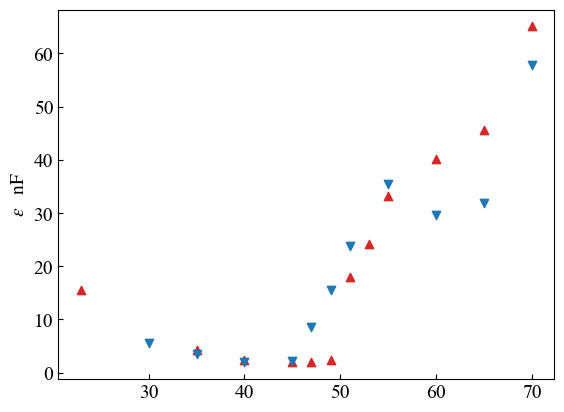

In [23]:
plt.ylabel("$\epsilon \quad\mathrm{nF}$")
plt.scatter(temp[heating_index],1/epsilon[heating_index], c="tab:red", marker="^")
plt.scatter(temp[cooling_index],1/epsilon[cooling_index], c="tab:blue", marker="v")

[49.         13.45552353  0.1         0.4513147 ]


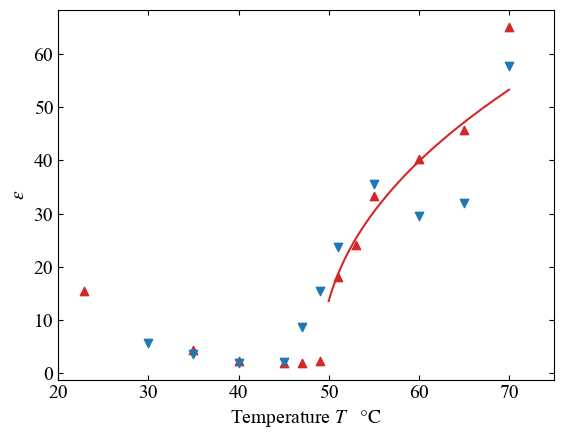

In [24]:
initial_guess = [50, 1.0, 0.0, 1]
lower_bounds =[49, 1.0, -0.1, 0]
upper_bounds =[51, 50.0, 0.1, 2]
popt = curve_fit(parafit, temp[63:74], 1/epsilon[63:74], p0=initial_guess, bounds=(lower_bounds, upper_bounds), maxfev=5000)[0]
print(popt)

fitcurve = lambda T: parafit(T, popt[0],popt[1], popt[2],popt[3])
T_values = np.linspace(50,70,1000)


# 目盛を上下作用にセット
f = plt.figure()
ax = f.add_subplot(111)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# プロットエリアの範囲等の整備
plt.xlim(20,75)
# plt.ylim(-0.01,0.61)
# plt.yticks([0, 0.5, 1, 1.5, 2.0])
# plt.ylim(0,2)

# フォントの選択
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] ='Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'

# 軸ラベル
plt.xlabel("Temperature $ T \quad\mathrm{\degree C}$")
plt.ylabel("$\epsilon$ ")

plt.plot(T_values,fitcurve(T_values), color = "tab:red")
plt.scatter(temp[heating_index],1/epsilon[heating_index], color = "tab:red", marker = "^", label = "Heating process")
plt.scatter(temp[cooling_index],1/epsilon[cooling_index], color = "tab:blue", marker = "v", label = "Cooling process")

# plt.legend()
# plt.text(41, 1.5, "$\propto(T-T_c)^{0.29}$", backgroundcolor = "white")
# plt.text(62, 1.5, "sample:TGS", backgroundcolor = "white")
# plt.annotate(text="$T_c = 50.4 \degree$C", xy=(51,0.1), xytext=(55,0.4), arrowprops=dict(color='black', width =1.0,headwidth=5.0,headlength=7.0,shrink=0.01))


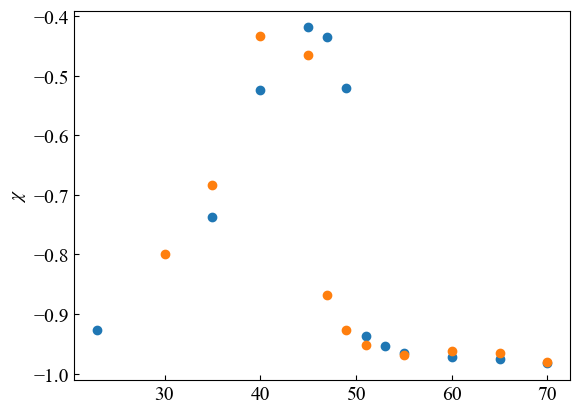

In [25]:
plt.ylabel("$\chi$")
plt.scatter(temp[heating_index],chi[heating_index], c="tab:blue")
plt.scatter(temp[cooling_index],chi[cooling_index], c="tab:orange")

## ヒステリシス曲線

### 電圧依存性

室温

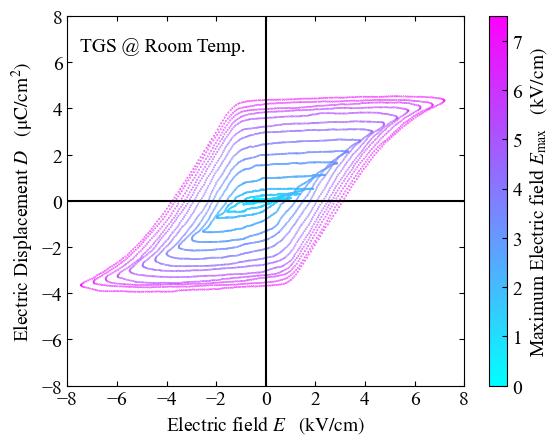

In [26]:
# 目盛を上下作用にセット
f = plt.figure()
ax = f.add_subplot(111)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# プロットエリアの範囲等の整備
plt.xlim(-8,8)
plt.ylim(-8,8)
plt.xticks([-8,-6,-4, -2, 0 ,2, 4, 6, 8])
plt.hlines([0],-8,8, "black")
plt.vlines([0],-8,8, "black")

# フォントの選択
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] ='Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'

# 軸ラベル
plt.xlabel("Electric field $ E \quad\mathrm{(kV/cm)}$")
plt.ylabel("Electric Displacement $ D \quad\mathrm{(\mu C/cm^2)}$ ")

# プロット
for i in range(0,15):
    EField = np.max(data[i][1][300:700])
    EField_list = np.full(1000, EField)
    plt.scatter(data[i][1][300:700],data[i][2][300:700], c=EField_list[300:700], cmap="cool", norm=Normalize(vmin=0, vmax=7.5),  s=0.1)

# カラーバーのラベル
plt.colorbar(label = "Maximum Electric field $ E_{\mathrm{max}} \quad\mathrm{(kV/cm)}$")
# その他要素
plt.text(-7.5, 6.5, "TGS @ Room Temp.", backgroundcolor = "white")

plt.show()


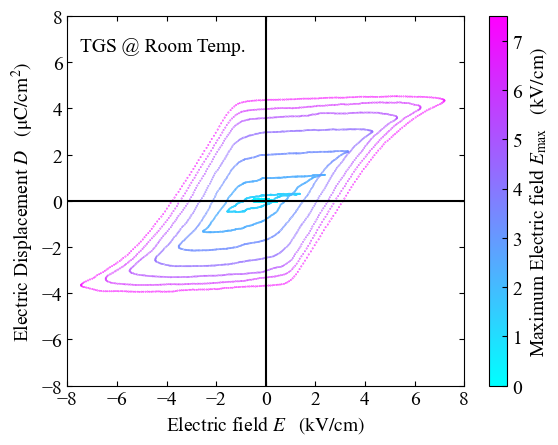

In [27]:
# 目盛を上下作用にセット
f = plt.figure()
ax = f.add_subplot(111)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# プロットエリアの範囲等の整備
plt.xlim(-8,8)
plt.ylim(-8,8)
plt.xticks([-8,-6,-4, -2, 0 ,2, 4, 6, 8])
plt.hlines([0],-8,8, "black")
plt.vlines([0],-8,8, "black")

# フォントの選択
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] ='Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'

# 軸ラベル
plt.xlabel("Electric field $ E \quad\mathrm{(kV/cm)}$")
plt.ylabel("Electric Displacement $ D \quad\mathrm{(\mu C/cm^2)}$ ")

# プロット
for i in range(0,15,2):
    EField = np.max(data[i][1][300:700])
    EField_list = np.full(1000, EField)
    plt.scatter(data[i][1][300:700],data[i][2][300:700], c=EField_list[300:700], cmap="cool", norm=Normalize(vmin=0, vmax=7.5),  s=0.1)

# カラーバーのラベル
plt.colorbar(label = "Maximum Electric field $ E_{\mathrm{max}} \quad\mathrm{(kV/cm)}$")
# その他要素
plt.text(-7.5, 6.5, "TGS @ Room Temp.", backgroundcolor = "white")

plt.show()


35 ℃

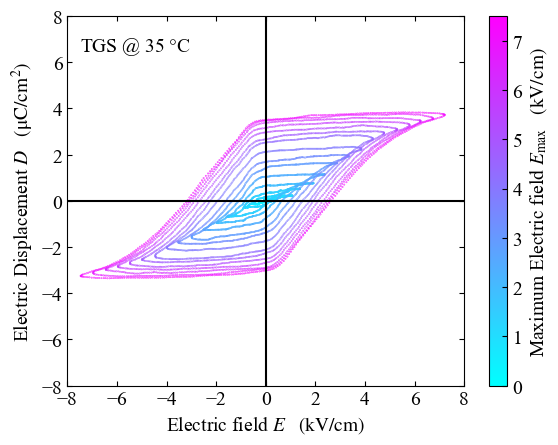

In [28]:
# 目盛を上下作用にセット
f = plt.figure()
ax = f.add_subplot(111)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# プロットエリアの範囲等の整備
plt.xlim(-8,8)
plt.ylim(-8,8)
plt.xticks([-8,-6,-4, -2, 0 ,2, 4, 6, 8])
plt.hlines([0],-8,8, "black")
plt.vlines([0],-8,8, "black")

# フォントの選択
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] ='Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'

# 軸ラベル
plt.xlabel("Electric field $ E \quad\mathrm{(kV/cm)}$")
plt.ylabel("Electric Displacement $ D \quad\mathrm{(\mu C/cm^2)}$ ")

# プロット
for i in range(15,30):
    EField = np.max(data[i][1][300:700])
    EField_list = np.full(1000, EField)
    plt.scatter(data[i][1][300:700],data[i][2][300:700], c=EField_list[300:700], cmap="cool", norm=Normalize(vmin=0, vmax=7.5),  s=0.1)

# カラーバーのラベル
plt.colorbar(label = "Maximum Electric field $ E_{\mathrm{max}} \quad\mathrm{(kV/cm)}$")
# その他要素
plt.text(-7.5, 6.5, "TGS @ 35 $\degree$C", backgroundcolor = "white")

plt.show()


40 ℃

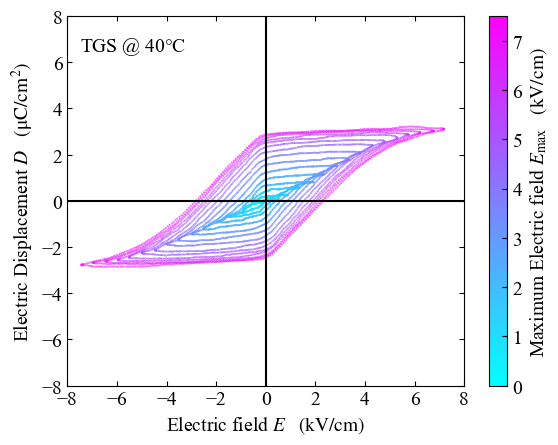

In [29]:
# 目盛を上下作用にセット
f = plt.figure()
ax = f.add_subplot(111)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# プロットエリアの範囲等の整備
plt.xlim(-8,8)
plt.ylim(-8,8)
plt.xticks([-8,-6,-4, -2, 0 ,2, 4, 6, 8])
plt.hlines([0],-8,8, "black")
plt.vlines([0],-8,8, "black")

# フォントの選択
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] ='Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'

# 軸ラベル
plt.xlabel("Electric field $ E \quad\mathrm{(kV/cm)}$")
plt.ylabel("Electric Displacement $ D \quad\mathrm{(\mu C/cm^2)}$ ")

# プロット
for i in range(30,45):
    EField = np.max(data[i][1][300:700])
    EField_list = np.full(1000, EField)
    plt.scatter(data[i][1][300:700],data[i][2][300:700], c=EField_list[300:700], cmap="cool", norm=Normalize(vmin=0, vmax=7.5),  s=0.1)

# カラーバーのラベル
plt.colorbar(label = "Maximum Electric field $ E_{\mathrm{max}} \quad\mathrm{(kV/cm)}$")
# その他要素
plt.text(-7.5, 6.5, "TGS @ 40$\degree$C", backgroundcolor = "white")

plt.show()


45 ℃

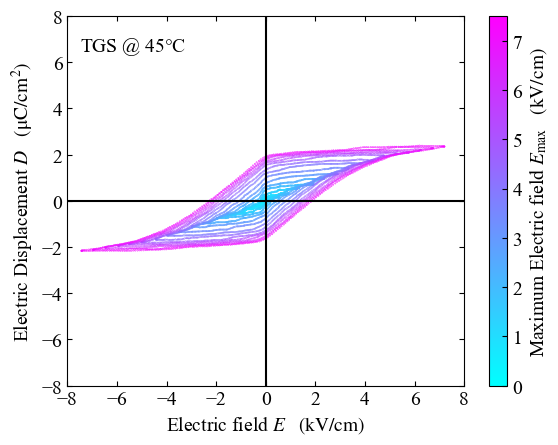

In [30]:
# 目盛を上下作用にセット
f = plt.figure()
ax = f.add_subplot(111)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# プロットエリアの範囲等の整備
plt.xlim(-8,8)
plt.ylim(-8,8)
plt.xticks([-8,-6,-4, -2, 0 ,2, 4, 6, 8])
plt.hlines([0],-8,8, "black")
plt.vlines([0],-8,8, "black")

# フォントの選択
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] ='Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'

# 軸ラベル
plt.xlabel("Electric field $ E \quad\mathrm{(kV/cm)}$")
plt.ylabel("Electric Displacement $ D \quad\mathrm{(\mu C/cm^2)}$ ")

# プロット
for i in range(45,61):
    EField = np.max(data[i][1][300:700])
    EField_list = np.full(1000, EField)
    plt.scatter(data[i][1][300:700],data[i][2][300:700], c=EField_list[300:700], cmap="cool", norm=Normalize(vmin=0, vmax=7.5),  s=0.1)

# カラーバーのラベル
plt.colorbar(label = "Maximum Electric field $ E_{\mathrm{max}} \quad\mathrm{(kV/cm)}$")
# その他要素
plt.text(-7.5, 6.5, "TGS @ 45$\degree$C", backgroundcolor = "white")

plt.show()


### 温度依存性

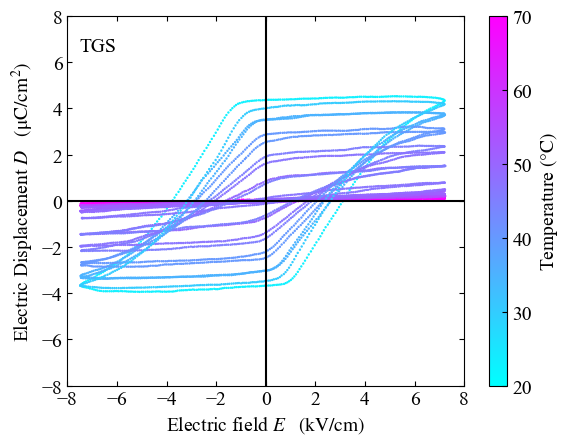

In [31]:
# 目盛を上下作用にセット
f = plt.figure()
ax = f.add_subplot(111)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# プロットエリアの範囲等の整備
plt.xlim(-8,8)
plt.ylim(-8,8)
plt.xticks([-8,-6,-4, -2, 0 ,2, 4, 6, 8])
plt.hlines([0],-8,8, "black")
plt.vlines([0],-8,8, "black")

# フォントの選択
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] ='Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'

# 軸ラベル
plt.xlabel("Electric field $ E \quad\mathrm{(kV/cm)}$")
plt.ylabel("Electric Displacement $ D \quad\mathrm{(\mu C/cm^2)}$ ")

# プロット
for i in heating_index:
    plt.scatter(data[i][1][300:700],data[i][2][300:700], c=data[i][4][300:700], cmap="cool", norm=Normalize(vmin=20, vmax=70),  s=0.5)
for i in cooling_index:
    plt.scatter(data[i][1][300:700],data[i][2][300:700], c=data[i][4][300:700], cmap="cool", norm=Normalize(vmin=20, vmax=70),  s=0.5)
# カラーバーのラベル
plt.colorbar(label = "Temperature $(\mathrm{\degree C})$")

# その他要素
plt.text(x=-7.5, y=6.5, s="TGS",backgroundcolor = "white")

plt.show()

相転移付近の昇温過程

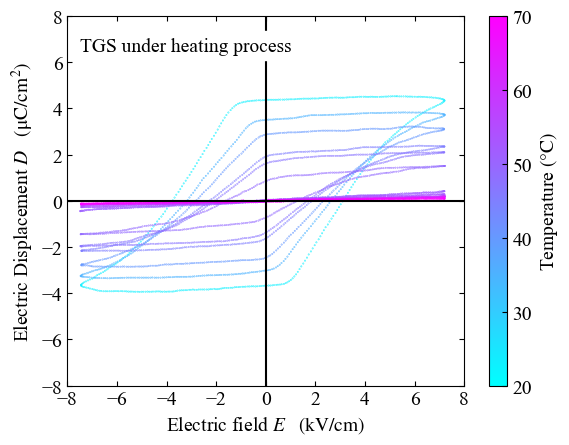

In [32]:
# 目盛を上下作用にセット
f = plt.figure()
ax = f.add_subplot(111)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# プロットエリアの範囲等の整備
plt.xlim(-8,8)
plt.ylim(-8,8)
plt.xticks([-8,-6,-4, -2, 0 ,2, 4, 6, 8])
plt.hlines([0],-8,8, "black")
plt.vlines([0],-8,8, "black")

# フォントの選択
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] ='Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'

# 軸ラベル
plt.xlabel("Electric field $ E \quad\mathrm{(kV/cm)}$")
plt.ylabel("Electric Displacement $ D \quad\mathrm{(\mu C/cm^2)}$ ")

# プロット
for i in heating_index:
    plt.scatter(data[i][1][300:700],data[i][2][300:700], c=data[i][4][300:700], cmap="cool", norm=Normalize(vmin=20, vmax=70),  s=0.1)
# カラーバーのラベル
plt.colorbar(label = "Temperature $(\mathrm{\degree C})$")

# その他要素
plt.text(x=-7.5, y=6.5, s="TGS under heating process",backgroundcolor = "white")

plt.show()

相転移付近の降温過程

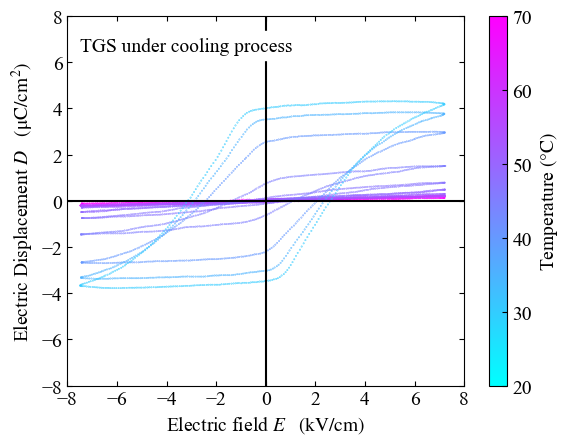

In [33]:
# 目盛を上下作用にセット
f = plt.figure()
ax = f.add_subplot(111)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# プロットエリアの範囲等の整備
plt.xlim(-8,8)
plt.ylim(-8,8)
plt.xticks([-8,-6,-4, -2, 0 ,2, 4, 6, 8])
plt.hlines([0],-8,8, "black")
plt.vlines([0],-8,8, "black")

# フォントの選択
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] ='Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'

# 軸ラベル
plt.xlabel("Electric field $ E \quad\mathrm{(kV/cm)}$")
plt.ylabel("Electric Displacement $ D \quad\mathrm{(\mu C/cm^2)}$")

# プロット
for i in cooling_index:
    plt.scatter(data[i][1][300:700],data[i][2][300:700], c=data[i][4][300:700], cmap="cool", norm=Normalize(vmin=20, vmax=70),  s=0.1)
# カラーバーのラベル
plt.colorbar(label = "Temperature $(\mathrm{\degree C})$")

# その他要素
plt.text(x=-7.5, y=6.5, s="TGS under cooling process",backgroundcolor = "white")

plt.show()